# Multiple Peaks Simulations

In this set of simulations, we will test power spectrum parameterization performance across power spectra with multiple peaks. 

To do so, we will simulate power spectra with a varying number of peaks with an aperiodic component in 'fixed' mode, all with varying parameters.

Performance will be evaluated by examining how well the algorithm can reconstruct the number of peaks, the aperiodic parameters, and the overall model fit.

In [1]:
from os.path import join as pjoin

import numpy as np

from fooof import FOOOFGroup, fit_fooof_3d
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [2]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [3]:
# Set random seed
set_random_seed(303)

In [4]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [5]:
# Set a folder name (for saving data & figures)
FOLDER = '02_multi-peak/'

In [6]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = False
SAVE_SIMS = False

### Simulate Power Spectra

In [7]:
# Set the number of power spectra - this is per n_peak condition
n_psds = N_PSDS

# Set the number of peaks to use
n_peaks = [0, 1, 2, 3, 4]

# Use generators to sample peak & aperiodic parameters
peaks = []
for n_peak in n_peaks:
    peaks.append(gen_peak_def(n_peak))
aps = gen_ap_def()

In [8]:
# Get data sizes
n_n_peaks = len(n_peaks)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [9]:
# Generate or load power spectra
data_name = 'multi_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_n_peaks, n_psds, n_freqs])
    sim_params = [None] * n_n_peaks

    # Generate simulated power spectra
    for n_ind, n_peak, peaks in zip(range(n_n_peaks), n_peaks, peaks):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, NLV,
                                    F_RES, return_params=True)
        
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(pjoin(FOLDER, data_name), freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(pjoin(FOLDER, data_name))
            
# Check shape
print('n_n_peaks, n_spectra, n_freqs : ', psds.shape)

n_n_peaks, n_spectra, n_freqs :  (5, 1000, 153)


In [10]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

### Fit Power Spectra with FOOOF

In [11]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(*FOOOF_SETTINGS, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [12]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_3d(fg, freqs, psds)

### Extract FOOOF fit Data

In [13]:
# Extract data of interest from FOOOF fits
_, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [14]:
# Calculate error
ap_errors = np.abs(ap_truths - ap_fits)

In [15]:
# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

In [16]:
# Get count of relation between number of simualated and fit peaks
n_peak_counter = count_peak_conditions(n_fit_peaks, n_peaks)

### Check Average Errors & Stats

In [17]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.min(temp), np.max(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.median(temp)))

Min/Max R^2: 	0.9515 	0.9998
Median  R^2: 	0.9989


In [18]:
# Collect data together
datas = {
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [19]:
# Print out the average error for each parameter, across number of peaks
#   Also prints out the average model error and R^2 per peak count
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

OFF
	 [0.00206841 0.00390507 0.01299035 0.04719272 0.0797766 ]
EXP
	 [0.00169257 0.003268   0.00880027 0.02824206 0.04619241]
ERR
	 [0.007943   0.00814784 0.00909312 0.01180639 0.01440901]
R^2
	 [0.99914161 0.99913616 0.99908922 0.99863444 0.99802549]


### Create Plots

#### Periodic Components

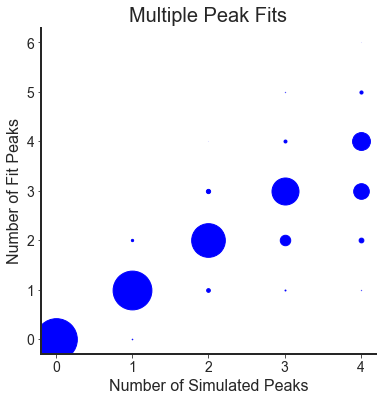

In [20]:
# Plot the correspondance between number of simulated peaks & number of fit peaks
plot_n_peaks_bubbles(n_peak_counter, ms_val=12,
                     save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'n_peaks_fit'))

#### Aperiodic Components

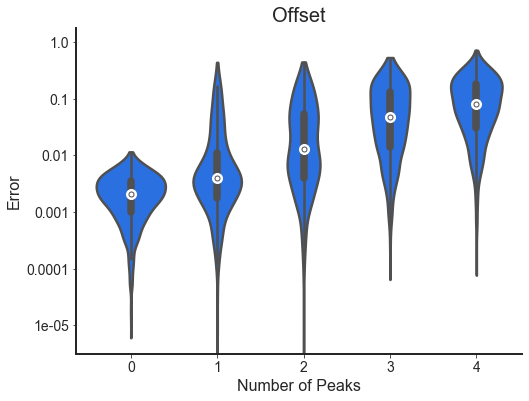

In [21]:
# Multi-peak fitting: plot error of aperiodic offset reconstruction across number of peaks
plot_errors_violin(off_errors, 'Offset',
                   x_axis='n_peaks', plt_log=True, ylim=[-5.5, 0.25], 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'))

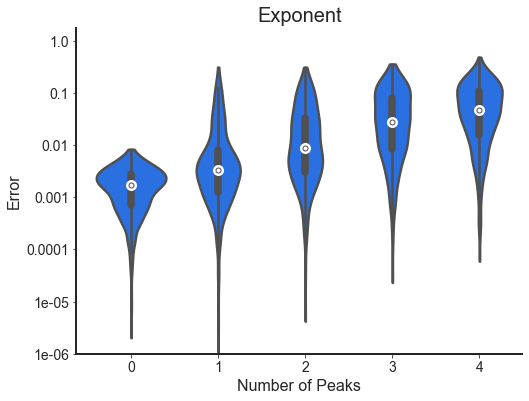

In [22]:
# Multi-peak fitting: plot error of aperiodic exponent reconstruction across number of peaks
plot_errors_violin(exp_errors, 'Exponent',
                   x_axis='n_peaks', plt_log=True, ylim=[-6, 0.25], 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

#### Goodness of Fit Measures

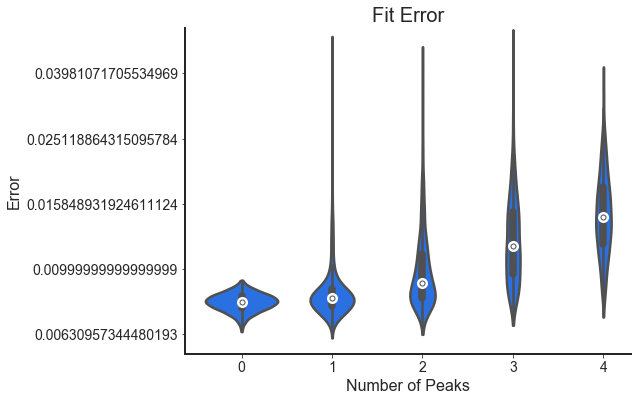

In [23]:
# Multi-peak fitting: plot error levels across number of peaks
plot_errors_violin(err_fits, 'Fit Error',
                   x_axis='n_peaks', plt_log=True, ylim=np.log10([0.0055, 0.055]), 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'))

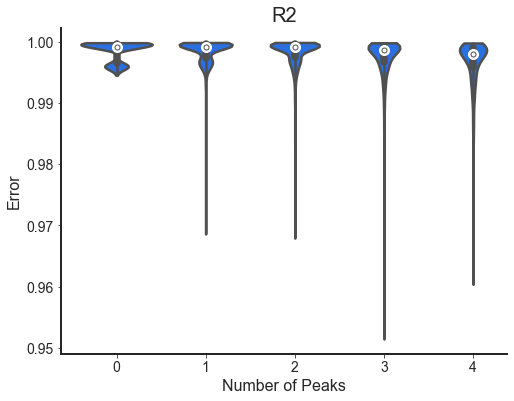

In [24]:
# Multi-peak fitting: plot R^2 levels across number of peaks
plot_errors_violin(r2_fits, 'R2',
                   x_axis='n_peaks', plt_log=False, 
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'))

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 0.5], periodic_params=[[6, 0.4, 1.0], [10, 0.25, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0625, 0.5407                                          
                                                                                                  
            

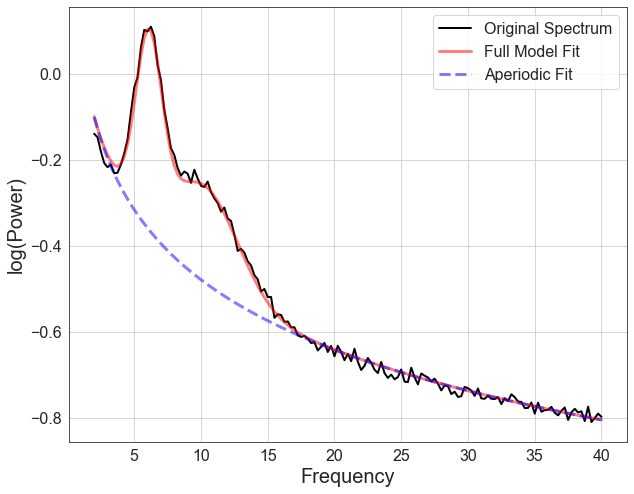

In [25]:
# Grab example case, plot & save out
ind = 0
fm = fgs[2].get_fooof(ind, True)
print(sim_params[2][ind])
fm.print_results()
fm.plot(save_fig=SAVE_FIG, file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_2peaks')

SimParams(aperiodic_params=[0, 1.0], periodic_params=[[6, 0.25, 2.0], [10, 0.2, 3.0], [13, 0.2, 2.0], [27, 0.2, 3.0]], nlv=0.01)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.1361, 1.0786                                          
                                                                               

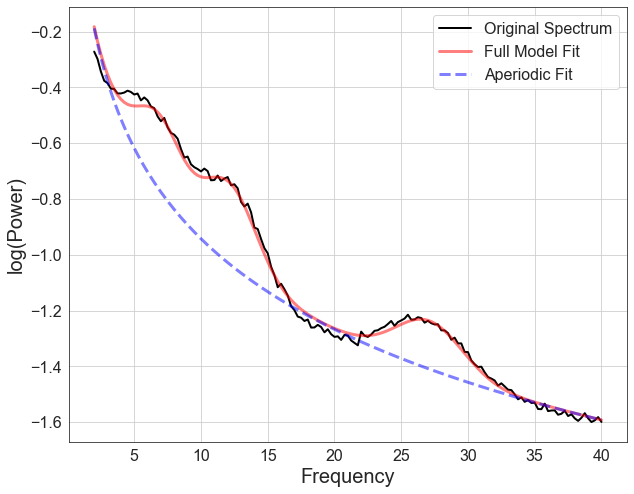

In [26]:
# Grab example case, plot & save out
ind = 0
fm = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm.print_results()
fm.plot(save_fig=SAVE_FIG, file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_peaks')